# Practica 4
## Objetivos

1. A partir del espectrograma Mel calcularemos los coeficientes MFCC (Mel Frequency Cepstral Coefficients)

2. A partir del espectrograma lineal extraeremos otras características (features) espectrales.

3. Construiremos el vector de features que va a “describir” al fichero de audio: Cada fichero *.wav se “representará” por un único vector de 85 componentes.

In [83]:
import os
import numpy as np
from collections import namedtuple
import scipy.io.wavfile as wav
import scipy.fft as fft
import matplotlib.pyplot as plt
import librosa as lr

In [84]:
# named tuple representing a signal
Signal = namedtuple("Signal", ["y", "fs", "file"])


# create a signal from a file
def signal_from_file(filename):
    # read the audio file
    fs, y = wav.read(filename)

    # normalize the signal if it is not already normalized
    # to normalize the signal we divide by the maximum possible value of the data type
    if np.any(abs(y) > 1):
        if np.issubdtype(y.dtype, np.integer):
            y = y / np.iinfo(y.dtype).max
        elif np.issubdtype(y.dtype, np.floating):
            y = y / np.finfo(y.dtype).max
        else:
            raise ValueError("Could not normalize signal")

    return Signal(y, fs, os.path.basename(filename))


# plot signal in continuous time
def plot_signal(y, fs, title):
    t = np.arange(len(y)) / fs

    plt.plot(t, y)
    plt.xlabel("Time (s)")
    plt.title(title)

    plt.show()

## Ejercicio 4.1
Recortamos la señal usando un VAD y la representamos.

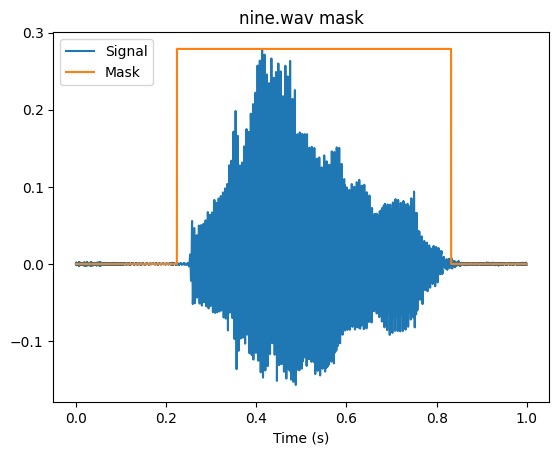

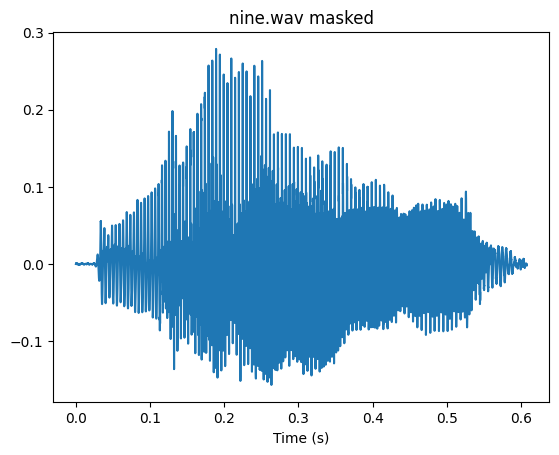

In [85]:
AUDIO_DIR = "audio/"

signal = signal_from_file(os.path.join(AUDIO_DIR, "nine.wav"))

frame_duration = 0.032  # frame duration in seconds
overlap_duration = frame_duration / 2  # overlap duration in seconds

frame_length = round(frame_duration * signal.fs)  # frame length in samples
overlap_samples = round(overlap_duration * signal.fs)  # overlap length in samples
n_fft = 2 ** (frame_length - 1).bit_length()  # FFT length

# mask the signal
masked_y, mask_idx = lr.effects.trim(signal.y, top_db=15)
mask = np.zeros(len(signal.y))
mask[mask_idx[0] : mask_idx[1]] = np.max(signal.y)

# plot the mask
t = np.arange(len(signal.y)) / signal.fs

plt.plot(t, signal.y)
plt.plot(t, mask)
plt.xlabel("Time (s)")
plt.title(f"{signal.file} mask")
plt.legend(["Signal", "Mask"])
plt.show()

# plot the masked signal
plot_signal(masked_y, signal.fs, f"{signal.file} masked")

## Ejercicio 4.2
Obtenemos el espectrograma de Mel y calculamos los coeficientes MFCC usando la transformada discreta del coseno y lo comparamos con el resultado de la propia función ofrecida por `librosa` para hacer el cálculo directo.

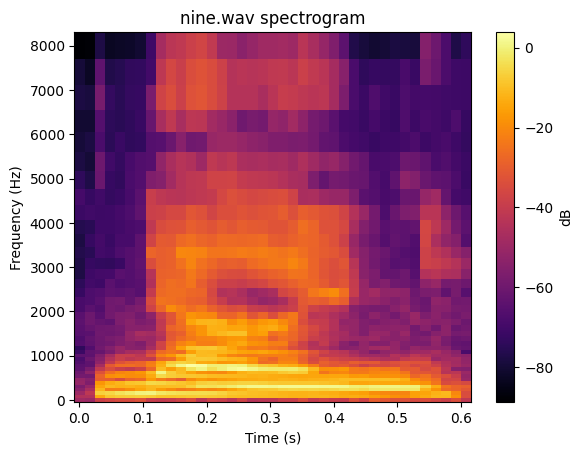

False
[-428.68337388 -413.53128181 -340.40232657]
[-423.48566742 -408.43024745 -340.16199202]
(13, 39)


In [86]:
n_mels = 40  # number of mel bands
n_mfcc = 13  # number of MFCC coefficients

fig, ax = plt.subplots()
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")

# compute the mel spectrogram
S = lr.feature.melspectrogram(
    y=masked_y,
    sr=signal.fs,
    n_fft=n_fft,
    hop_length=overlap_samples,
    n_mels=n_mels,
)

# plot the mel spectrogram
t = lr.times_like(S, sr=signal.fs, hop_length=overlap_samples)
f = lr.mel_frequencies(n_mels=n_mels, fmin=0, fmax=signal.fs / 2)
T, F = np.meshgrid(t, f)

pcm = ax.pcolormesh(T, F, 10 * np.log10(S), cmap="inferno")
fig.colorbar(pcm, ax=ax, label="dB")

plt.show()

# calculate the MFCCs from the mel spectrogram
mfcc_formula = fft.dct(10 * np.log10(S), axis=0, norm="ortho")[:n_mfcc]

# calculate the mffcc coefficients directly using librosa
mfcc = lr.feature.mfcc(
    y=masked_y,
    sr=signal.fs,
    n_mfcc=n_mfcc,
    n_fft=n_fft,
    hop_length=overlap_samples,
    n_mels=n_mels,
)

print(np.allclose(mfcc_formula, mfcc))
print(mfcc_formula[0, :3])
print(mfcc[0, :3])